In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import sys
import os
import nltk
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gensim.models import KeyedVectors
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import ADASYN
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import ComplementNB, BernoulliNB, MultinomialNB
from sklearn.metrics import classification_report, auc, roc_curve, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.base import TransformerMixin
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

sys.path.append("..")
from eventepi.pipeline import ExtractSentencesAndLabel, RecommenderLabeling
from eventepi.my_utils import split_list_and_distribute_to_new_rows

In [12]:
np.random.seed(13353)

In [13]:
def print_performance(clf, y_test, X_test, save=False):
    try:
        fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    except (AttributeError, IndexError):
        fpr, tpr, _ = roc_curve(y_test, clf.predict(X_test))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if save:
        plt.savefig(f'{name}.pdf', format='pdf')
    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.plot(fpr, tpr)
    y_pred = clf.predict(X_test)
    print(classification_report_imbalanced(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print('AUC score: {:3f}'.format(auc(fpr, tpr)))

# Count/Date Classifier

In [14]:
df_counts = ExtractSentencesAndLabel("counts").data_output()

df_counts["sentence"] = (df_counts["sentence"]
                         .apply(lambda x: 
                                re.sub(r"([0-9a-zA-Z]+)\.([A-Za-z]+\s)",
                                       r"\g<1>. \g<2>",
                                       x)
                               )
                        )

In [15]:
print(f"There are {len(df_counts)} sentences containing a count entity. {sum(df_counts['label'])} of them contain a key count entity")

There are 2443 sentences containing a count entity. 198 of them contain a key count entity


In [16]:
count_clf = Pipeline([
    ('vect', CountVectorizer(stop_words="english",
                             tokenizer=word_tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),])
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 5)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1, 0.5, 0.1, 1e-3)}
count_gs_clf = GridSearchCV(count_clf, 
                            parameters, 
                            iid=False, 
                            cv=4,
                            n_jobs=(os.cpu_count()//2))

(train_texts_counts, 
 dev_texts_counts, 
 train_cats_counts, 
 dev_cats_counts) = train_test_split(df_counts['sentence'],
                                     df_counts['label'],
                                     test_size=.2,
                                     random_state=13353,
                                     stratify=df_counts["label"]
                                    )

count_gs_clf.fit(train_texts_counts, 
                 train_cats_counts, 
                 clf__sample_weight=compute_sample_weight(class_weight='balanced', y=train_cats_counts))

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=False, n_jobs=2,
       param_grid={'vect__ngram_range': [(1, 1), (1, 2), (1, 5)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1, 0.5, 0.1, 0.001)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

                   pre       rec       spe        f1       geo       iba       sup

      False       0.97      0.88      0.65      0.92      0.76      0.58       449
       True       0.32      0.65      0.88      0.43      0.76      0.56        40

avg / total       0.91      0.86      0.67      0.88      0.76      0.58       489

[[394  55]
 [ 14  26]]
AUC score: 0.848357


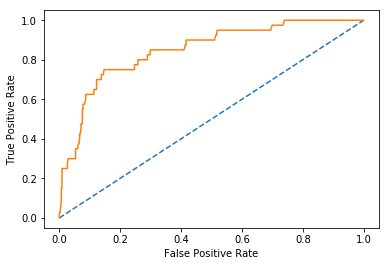

In [17]:
print_performance(count_gs_clf, dev_cats_counts, dev_texts_counts)

In [18]:
count_clf_ber = Pipeline([
    ('vect', CountVectorizer(stop_words="english",
                             tokenizer=word_tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB()),])

parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1, 0.5, 0.1, 1e-2, 1e-3)}
count_gs_clf_ber = GridSearchCV(count_clf_ber, 
                                parameters, 
                                iid=False, 
                                cv=4,
                                n_jobs=(os.cpu_count()//2))

count_gs_clf_ber.fit(train_texts_counts, 
                     train_cats_counts, 
                     clf__sample_weight=compute_sample_weight(class_weight='balanced', y=train_cats_counts))

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...se, use_idf=True)), ('clf', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=False, n_jobs=2,
       param_grid={'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1, 0.5, 0.1, 0.01, 0.001)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

                   pre       rec       spe        f1       geo       iba       sup

      False       0.96      0.88      0.55      0.91      0.69      0.50       449
       True       0.28      0.55      0.88      0.37      0.69      0.47        40

avg / total       0.90      0.85      0.58      0.87      0.69      0.49       489

[[393  56]
 [ 18  22]]
AUC score: 0.796381


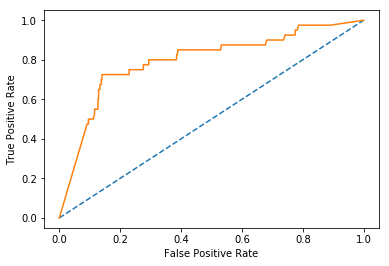

In [19]:
print_performance(count_gs_clf_ber, dev_cats_counts, dev_texts_counts)

In [20]:
df_dates = ExtractSentencesAndLabel("dates").data_output()

In [21]:
df_dates["sentence"] = (df_dates["sentence"]
                         .apply(lambda x: 
                                re.sub(r"([0-9a-zA-Z]+)\.([A-Za-z]+\s)",
                                       r"\g<1>. \g<2>",
                                       x)
                               )
                        )


In [22]:
print(f"There are {len(df_dates)} sentences containing a count entity. {sum(df_dates['label'])} of them contain a key count entity")

There are 192 sentences containing a count entity. 46 of them contain a key count entity


In [23]:
date_clf = Pipeline([
    ('vect', CountVectorizer(stop_words="english",
                             tokenizer=word_tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),])
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 5)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1, 0.5, 0.1, 1e-3)}
date_gs_clf = GridSearchCV(date_clf, 
                            parameters, 
                            iid=False, 
                            cv=4,
                            n_jobs=(os.cpu_count()//2))

(train_texts_counts, 
 dev_texts_counts, 
 train_cats_counts, 
 dev_cats_counts) = train_test_split(df_dates['sentence'],
                                     df_dates['label'],
                                     test_size=.2,
                                     random_state=13353,
                                     stratify=df_dates["label"]
                                    )

date_gs_clf.fit(train_texts_counts, 
                train_cats_counts, 
                clf__sample_weight=compute_sample_weight(class_weight='balanced', y=train_cats_counts))

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=False, n_jobs=2,
       param_grid={'vect__ngram_range': [(1, 1), (1, 2), (1, 5)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1, 0.5, 0.1, 0.001)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

                   pre       rec       spe        f1       geo       iba       sup

      False       0.84      0.87      0.44      0.85      0.62      0.40        30
       True       0.50      0.44      0.87      0.47      0.62      0.37         9

avg / total       0.76      0.77      0.54      0.76      0.62      0.39        39

[[26  4]
 [ 5  4]]
AUC score: 0.609259


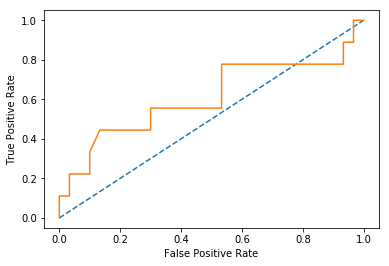

In [24]:
print_performance(date_gs_clf, dev_cats_counts, dev_texts_counts)

In [25]:
date_clf_ber = Pipeline([
    ('vect', CountVectorizer(stop_words="english",
                             tokenizer=word_tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB()),])
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 5)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1, 0.5, 0.1, 1e-3)}
date_gs_clf_ber = GridSearchCV(date_clf_ber, 
                               parameters, 
                               iid=False, 
                               cv=4,
                               n_jobs=(os.cpu_count()//2),
                              )

(train_texts_counts, 
 dev_texts_counts, 
 train_cats_counts, 
 dev_cats_counts) = train_test_split(df_dates['sentence'],
                                     df_dates['label'],
                                     test_size=.2,
                                     random_state=13353,
                                     stratify=df_dates["label"]
                                    )

date_gs_clf_ber.fit(train_texts_counts, 
                train_cats_counts, 
                clf__sample_weight=compute_sample_weight(class_weight='balanced', y=train_cats_counts))

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...se, use_idf=True)), ('clf', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=False, n_jobs=2,
       param_grid={'vect__ngram_range': [(1, 1), (1, 2), (1, 5)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1, 0.5, 0.1, 0.001)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

                   pre       rec       spe        f1       geo       iba       sup

      False       0.81      0.87      0.33      0.84      0.54      0.30        30
       True       0.43      0.33      0.87      0.38      0.54      0.27         9

avg / total       0.72      0.74      0.46      0.73      0.54      0.30        39

[[26  4]
 [ 6  3]]
AUC score: 0.612963


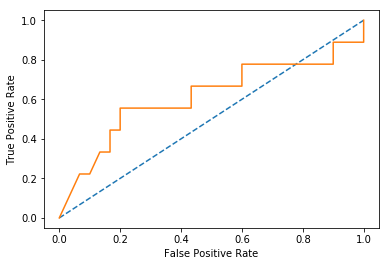

In [26]:
print_performance(date_gs_clf_ber, dev_cats_counts, dev_texts_counts)

## Count/Date Classifier: Most Informative Words

In [94]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [95]:
show_most_informative_features(count_gs_clf.best_estimator_.named_steps['vect'], 
                               count_gs_clf.best_estimator_.named_steps['clf'])

	-15.4559	$              		-2.7094	,              
	-15.4559	'              		-3.1042	.              
	-15.4559	'debilitating  		-3.8440	cases          
	-15.4559	'steadily      		-4.0339	)              
	-15.4559	'zero          		-4.0339	(              
	-15.4559	*              		-4.2190	reported       
	-15.4559	**             		-4.4853	case           
	-15.4559	*data          		-4.5814	new            
	-15.4559	*new           		-4.5953	health         
	-15.4559	*people        		-4.6256	outbreak       
	-15.4559	+234           		-4.7283	confirmed      
	-15.4559	+675           		-5.0905	disease        
	-15.4559	,0.66          		-5.1153	2018           
	-15.4559	-6             		-5.2149	polio          
	-15.4559	-80⁰c          		-5.2368	province       
	-15.4559	-le            		-5.2427	week           
	-15.4559	-péndé.le      		-5.3000	patient        
	-15.4559	...            		-5.3391	1              
	-15.4559	.a             		-5.3757	total          
	-15.4559	.about         		-5.3

## Use NLTK prebuild function

In [31]:
df_sent = ExtractSentencesAndLabel('counts').data_output()

In [32]:
df_sent["sentence"] = (df_sent["sentence"]
                         .apply(lambda x: 
                                re.sub(r"([0-9a-zA-Z]+)\.([A-Za-z]+\s)",
                                       r"\g<1>. \g<2>",
                                       x)
                               )
                        )
df_sent["sentence"] = df_sent["sentence"].apply(word_tokenize)
df_sent["sentence"] = (df_sent["sentence"]
                         .apply(lambda x: [i.lower() for i in x if i.isalnum()])
                        )
df_sent["sentence"] = df_sent["sentence"].apply(lambda x: " ".join(x))

In [33]:
df_sent['sentence']= df_sent['sentence'].apply(lambda x: list(set(x.split()) - set(stopwords.words('english'))))

In [34]:
df_sent = split_list_and_distribute_to_new_rows(df_sent, 'sentence')

In [35]:
as_tuples = df_sent.apply(tuple, axis=1).tolist()
as_tuples = [({'word':word}, label) for label, word in as_tuples]

In [36]:
clf = nltk.NaiveBayesClassifier.train(as_tuples)
clf.show_most_informative_features(30)

Most Informative Features
                    word = 'variant'        True : False  =     34.4 : 1.0
                    word = 'poultry'        True : False  =     30.0 : 1.0
                    word = 'guangxi'        True : False  =     27.8 : 1.0
                    word = 'laibin'         True : False  =     24.5 : 1.0
                    word = 'pennsylvania'   True : False  =     21.3 : 1.0
                    word = 'h1n2'           True : False  =     21.3 : 1.0
                    word = '13for'          True : False  =     21.3 : 1.0
                    word = 'straight'       True : False  =     21.3 : 1.0
                    word = 'fair'           True : False  =     21.3 : 1.0
                    word = 'desert'         True : False  =     19.1 : 1.0
                    word = 'bulgaria'       True : False  =     19.1 : 1.0
                    word = 'squirrels'      True : False  =     19.1 : 1.0
                    word = 'lived'          True : False  =     17.5 : 1.0

In [37]:
df_sent_date = ExtractSentencesAndLabel('dates').data_output()
df_sent_date["sentence"] = (df_sent_date["sentence"]
                            .apply(lambda x: 
                                   re.sub(r"([0-9a-zA-Z]+)\.([A-Za-z]+\s)",
                                          r"\g<1>. \g<2>",
                                          x)
                                  )
                           )
df_sent_date["sentence"] = df_sent_date.sentence.apply(word_tokenize)

df_sent_date["sentence"] = (df_sent_date["sentence"]
                         .apply(lambda x: [i.lower() for i in x if i.isalnum()])
                        )

df_sent_date["sentence"] = df_sent_date["sentence"].apply(lambda x: " ".join(x))
df_sent_date['sentence']= df_sent_date['sentence'].apply(lambda x: list(set(x.split()) - set(stopwords.words('english'))))
df_sent_date = split_list_and_distribute_to_new_rows(df_sent_date, 'sentence')
as_tuples_date = df_sent_date.apply(tuple, axis=1).tolist()
as_tuples_date = [({'word':word}, label) for label, word in as_tuples_date]

In [38]:
clf_date = nltk.NaiveBayesClassifier.train(as_tuples_date)
clf_date.show_most_informative_features(20)

Most Informative Features
                    word = 'worm'           True : False  =      6.2 : 1.0
                    word = 'emerging'       True : False  =      5.6 : 1.0
                    word = 'northern'       True : False  =      5.6 : 1.0
                    word = 'occurring'      True : False  =      5.6 : 1.0
                    word = 'syria'          True : False  =      5.6 : 1.0
                    word = 'patients'      False : True   =      5.5 : 1.0
                    word = 'still'          True : False  =      4.0 : 1.0
                    word = 'japan'          True : False  =      4.0 : 1.0
                    word = 'central'        True : False  =      4.0 : 1.0
                    word = 'every'          True : False  =      4.0 : 1.0
                    word = 'china'          True : False  =      4.0 : 1.0
                    word = 'protected'      True : False  =      4.0 : 1.0
                    word = 'launches'       True : False  =      4.0 : 1.0

# Recommendation Classifier

In [5]:
df_recommand = RecommenderLabeling().data_output()
df_recommand["extracted_text"] = (df_recommand["extracted_text"]
                                  .apply(lambda x: 
                                         re.sub(r"([0-9a-zA-Z]+)\.([A-Za-z]+\s)",
                                                r"\g<1>. \g<2>",
                                                x)
                                        )
                                 )

In [6]:
text_clf = Pipeline([
    ('vect', CountVectorizer(stop_words="english",
                             tokenizer=word_tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 5)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1, 0.5, 0.1, 1e-3)}
gs_text_clf = GridSearchCV(text_clf, 
                           parameters, 
                           iid=False, 
                           cv=4,
                           n_jobs=(os.cpu_count()//2),
                              )

In [7]:
(train_texts_counts, 
 dev_texts_counts, 
 train_cats_counts, 
 dev_cats_counts) = train_test_split(df_recommand["extracted_text"],
                                     df_recommand['label'],
                                     test_size=.2,
                                     random_state=13353,
                                     stratify=df_recommand["label"]
                                    )

In [8]:
gs_text_clf.fit(train_texts_counts, 
                train_cats_counts, 
                clf__sample_weight=compute_sample_weight(class_weight='balanced', y=train_cats_counts))

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=False, n_jobs=2,
       param_grid={'vect__ngram_range': [(1, 1), (1, 2), (1, 5)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1, 0.5, 0.1, 0.001)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

                   pre       rec       spe        f1       geo       iba       sup

      False       0.96      0.97      0.19      0.97      0.43      0.20       615
       True       0.26      0.19      0.97      0.22      0.43      0.17        32

avg / total       0.92      0.93      0.23      0.93      0.43      0.20       647

[[598  17]
 [ 26   6]]
AUC score: 0.775965


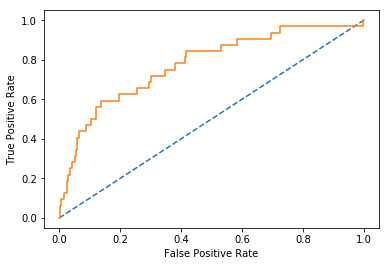

In [9]:
print_performance(gs_text_clf, dev_cats_counts, dev_texts_counts)

In [10]:
text_clf_comp = Pipeline([
    ('vect', CountVectorizer(stop_words="english",
                             tokenizer=word_tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', ComplementNB()),
])
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 5)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1, 0.5, 0.1, 1e-3)}
gs_text_clf_comp = GridSearchCV(text_clf_comp, 
                                parameters, 
                                iid=False, 
                                cv=4,
                                n_jobs=3,
                               )

In [11]:
gs_text_clf_comp.fit(train_texts_counts, 
                     train_cats_counts, 
                     clf__sample_weight=compute_sample_weight(class_weight='balanced', y=train_cats_counts))

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...lse, use_idf=True)), ('clf', ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False))]),
       fit_params=None, iid=False, n_jobs=3,
       param_grid={'vect__ngram_range': [(1, 1), (1, 2), (1, 5)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1, 0.5, 0.1, 0.001)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

                   pre       rec       spe        f1       geo       iba       sup

      False       0.96      0.97      0.19      0.97      0.43      0.20       615
       True       0.26      0.19      0.97      0.22      0.43      0.17        32

avg / total       0.92      0.93      0.23      0.93      0.43      0.20       647

[[598  17]
 [ 26   6]]
AUC score: 0.775965


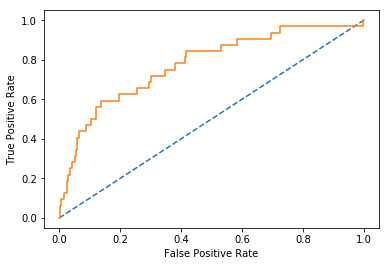

In [12]:
print_performance(gs_text_clf_comp, dev_cats_counts, dev_texts_counts)

# CNN classifier

See the performance of the classifier in the LRP_analysis notebook

# Embedded Classifier

In [65]:
class MeanEmbeddingTransformer(TransformerMixin):
    
    def __init__(self):
        self._vocab, self._E = self._load_words()
        
    
    def _load_words(self):
        E = {}
        vocab = []
        wv = KeyedVectors.load("self_trained_200", mmap="r")
        vocab = [i for i in wv.wv.vocab.keys()]
        vectors = e = np.array([i for i in wv.wv.vectors])
        E = dict(zip(vocab, vectors))
        return np.array(vocab), E            

    
    def _get_word(self, v):
        for i, emb in enumerate(self._E):
            if np.array_equal(emb, v):
                return self._vocab[i]
        return None
    
    def _doc_mean(self, doc):
        return np.mean(np.array([self._E[w.lower().strip()] for w in doc if w.lower().strip() in self._E]), axis=0)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array([self._doc_mean(doc) for doc in X])
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [66]:
df_recommand = RecommenderLabeling().data_output()
df_recommand["extracted_text"] = (df_recommand["extracted_text"]
                                  .apply(lambda x: 
                                         re.sub(r"([0-9a-zA-Z]+)\.([A-Za-z]+\s)",
                                                r"\g<1>. \g<2>",
                                                x)
                                        )
                                 )

In [67]:
df_recommand['label'].value_counts()

False    3072
True      160
Name: label, dtype: int64

In [68]:
X = df_recommand['extracted_text'].values
y = df_recommand['label'].values

In [69]:
def tokenize_and_transform(X, sample_size):
    articles = X
    vectors = [word_tokenize(doc) for doc in articles[:sample_size]]
    met = MeanEmbeddingTransformer()
    X_transform = met.fit_transform(vectors)
    return X_transform

In [70]:
X_transform = tokenize_and_transform(X, len(X))

c:\users\abbooda\appdata\local\continuum\anaconda3\envs\rki\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [71]:
np.savetxt('X_embed.csv', X_transform, delimiter=',')

In [72]:
X_transform = np.loadtxt('X_embed.csv', delimiter=',')

In [73]:
np.shape(X_transform)

(3232, 200)

In [74]:
np.shape(y)

(3232,)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_transform,
                                                    y,
                                                    test_size=.2,
                                                    random_state=13353,
                                                    stratify=y
                                                   )
ada = ADASYN(random_state=0)
X_resample, y_resample = ada.fit_sample(X_train, y_train)

c:\users\abbooda\appdata\local\continuum\anaconda3\envs\rki\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


                   pre       rec       spe        f1       geo       iba       sup

      False       0.97      0.72      0.62      0.82      0.67      0.45       615
       True       0.10      0.62      0.72      0.18      0.67      0.44        32

avg / total       0.93      0.71      0.63      0.79      0.67      0.45       647

[[440 175]
 [ 12  20]]
AUC score: 0.677134


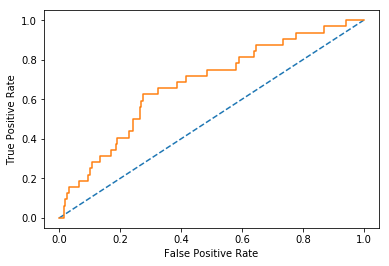

In [83]:
lr = LogisticRegression()
lr.fit(X_resample, 
       y_resample, 
       sample_weight=compute_sample_weight(class_weight='balanced', y=y_resample))
print_performance(lr, y_test, X_test)

                   pre       rec       spe        f1       geo       iba       sup

      False       0.97      0.55      0.69      0.70      0.61      0.37       615
       True       0.07      0.69      0.55      0.13      0.61      0.38        32

avg / total       0.93      0.56      0.68      0.67      0.61      0.37       647

[[338 277]
 [ 10  22]]
AUC score: 0.644741


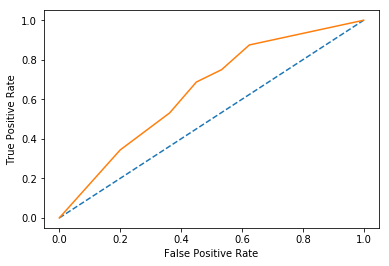

In [85]:
knn = KNeighborsClassifier()
knn.fit(X_resample, 
        y_resample
       )
print_performance(knn, y_test, X_test)

                   pre       rec       spe        f1       geo       iba       sup

      False       0.98      0.30      0.88      0.46      0.51      0.25       615
       True       0.06      0.88      0.30      0.11      0.51      0.28        32

avg / total       0.93      0.33      0.85      0.44      0.51      0.25       647

[[184 431]
 [  4  28]]
AUC score: 0.610798


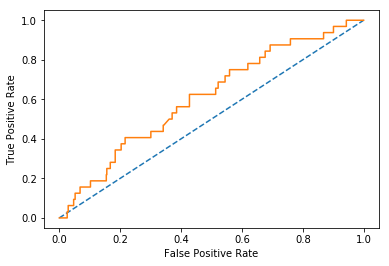

In [86]:
svc = SVC(probability=True, gamma='scale')
svc.fit(X_resample, 
       y_resample, 
       sample_weight=compute_sample_weight(class_weight='balanced', y=y_resample))
print_performance(svc, y_test, X_test)

                   pre       rec       spe        f1       geo       iba       sup

      False       0.97      0.89      0.50      0.93      0.67      0.46       615
       True       0.19      0.50      0.89      0.28      0.67      0.43        32

avg / total       0.93      0.87      0.52      0.90      0.67      0.46       647

[[548  67]
 [ 16  16]]
AUC score: 0.788516


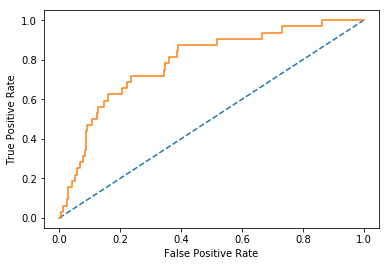

In [89]:
mlp = MLPClassifier(max_iter=2000, early_stopping=True)
mlp.fit(X_resample, 
       y_resample)
print_performance(mlp, y_test, X_test)

                   pre       rec       spe        f1       geo       iba       sup

      False       0.96      0.90      0.22      0.93      0.44      0.21       615
       True       0.10      0.22      0.90      0.14      0.44      0.18        32

avg / total       0.91      0.86      0.25      0.89      0.44      0.21       647

[[551  64]
 [ 25   7]]
AUC score: 0.678862


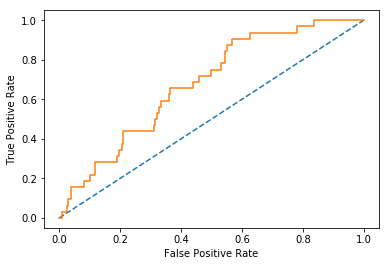

In [93]:
gbc = GradientBoostingClassifier(n_estimators =50)
gbc.fit(X_resample, 
        y_resample)
print_performance(gbc, y_test, X_test)

# Old Code

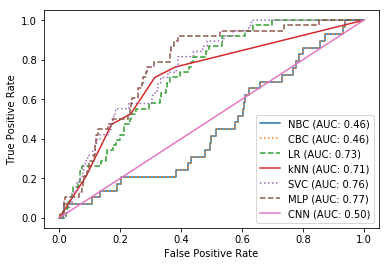

In [120]:
# clfs = [text_clf, text_clf_c, lr, knn, svc, svc_l, mlp]
# nlp2 = spacy.load(Path("spacy_output"))
# markers = ['-', ':', '--', '-', ":", "--", "-"]
# names = ["NBC", "CBC", "LR", "kNN", "SVC", "Lin. SVC", "MLP"]
clfs = [text_clf, text_clf_c, lr, knn, svc, mlp]
nlp2 = spacy.load(Path("spacy_output"))
markers = ['-', ':', '--', '-', ":", "--", "-"]
names = ["NBC", "CBC", "LR", "kNN", "SVC", "MLP"]
for i, clf in enumerate(clfs):
    try:
        if i in [0,1]:
            y_pred = clf.predict_proba(dev_texts)
            fpr, tpr, _ = roc_curve(dev_cats, y_pred[:,1])
            auc_score = auc(fpr, tpr)
        else:  
            y_pred = clf.predict_proba(X_test)
            fpr, tpr, _ = roc_curve(y_test, y_pred[:,1])
            auc_score = auc(fpr, tpr)
    except AttributeError:
        y_pred = clf.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        auc_score = auc(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.savefig(f'{name}.pdf', format='pdf')
    plt.plot(fpr, tpr, linestyle=markers[i], label=f"{names[i]} (AUC: {auc_score:.2f})")

import operator
X_train_s, X_test_s, y_train, y_test = train_test_split(X[:3200],
                                                    y[:3200], random_state=0)
y_pred = [nlp2(test_text).cats["Relevant"] for test_text in X_test_s]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.savefig(f'{name}.pdf', format='pdf')
plt.plot(fpr, tpr, linestyle='-', label=f"CNN (AUC: {auc_score:.2f})")
plt.legend(loc=4)
# plt.savefig('roc_curves.pdf', format='pdf')
plt.show()

In [115]:
import operator
X_train_s, X_test_s, y_train, y_test = train_test_split(X[:3200],
                                                        y[:3200], random_state=13353)
y_pred = [max(example.items(), key=operator.itemgetter(1))[0] == "Relevant" for test_text in X_test_s]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)
print(classification_report_imbalanced(y_test, y_pred))
#plt.savefig(f'{name}.pdf', format='pdf')


                   pre       rec       spe        f1       geo       iba       sup

      False       0.95      1.00      0.00      0.98      0.00      0.00       762
       True       0.00      0.00      1.00      0.00      0.00      0.00        38

avg / total       0.91      0.95      0.05      0.93      0.00      0.00       800



In [22]:
example = nlp2('ADas').cats

In [23]:
example.items()

dict_items([('Relevant', 4.539787187241018e-05), ('Irrelevant', 0.9999545812606812)])

In [24]:
clfs = [count_gs_clf, count_gs_clf_ber, date_gs_clf, date_gs_clf_ber]
markers = ['-', ':', '--', '-', ":", "--", "-"]
names = ["MNB (Counts)", "BNB (Counts)", "MNB (Dates)", "BNB (Dates)",]
for i, clf in enumerate(clfs):
    try:
        if i in [0,1]:
            y_pred = clf.predict_proba(dev_texts_counts)
            fpr, tpr, _ = roc_curve(dev_cats_counts, y_pred[:,1])
            auc_score = auc(fpr, tpr)
        else:  
            y_pred = clf.predict_proba(dev_texts_dates)
            fpr, tpr, _ = roc_curve(dev_cats_dates, y_pred[:,1])
            auc_score = auc(fpr, tpr)
    except AttributeError:
        print("asda")
        y_pred = clf.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        auc_score = auc(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.savefig(f'{name}.pdf', format='pdf')
    plt.plot(fpr, tpr, linestyle=markers[i], label=f"{names[i]} (AUC: {auc_score:.2f})")

plt.legend(loc=4)
plt.savefig('roc_curves_key.pdf', format='pdf')
plt.show()

NameError: name 'text_clf_counts' is not defined

## Other classifier

In [ ]:
gs = GridSearchCV(LogisticRegression(), 
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1]}, scoring="roc_auc", cv=4)
gs = gs.fit(X_resample, y_resample)
print(gs.best_params_)
print('best score: {:3f}'.format(gs.best_score_))
plot_roc(gs, X_resample, y_resample)

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
gs = GridSearchCV(LinearSVC(), 
             param_grid=param_grid, scoring="roc_auc", cv=4)
gs = gs.fit(X_resample, y_resample)
print(gs.best_params_)
print('best score: {:3f}'.format(gs.best_score_))
plot_roc(gs, X_resample, y_resample)

In [ ]:
param_grid = {'activation': ['relu', 'logistic', 'tanh'],
              'alpha': [0.0001, 0.001, 0.01],
              'learning_rate': ['constant', 'invscaling', 'adaptive'], 'tol': [0.01]}
gs = GridSearchCV(MLPClassifier(), 
             param_grid=param_grid, scoring="roc_auc", cv=4)
gs = gs.fit(X_transform, y[:3200])
print(gs.best_params_)
print('best score: {:3f}'.format(gs.best_score_))
plot_roc(gs, X_resample, y_resample)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
X_transform_cluster = KMeans(n_clusters=5).fit_transform(X_transform, y[:3200])

In [ ]:
rus = RandomUnderSampler(random_state=0)
X_resample_cluster, y_resample_cluster = rus.fit_sample(X_transform_cluster, y[:X_transform_cluster.shape[0]])

In [ ]:
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X_resample_cluster,
                                                    y_resample_cluster, stratify=y_resample_cluster, random_state=0)

In [ ]:
lr = LogisticRegression()
print_scores(lr, X_train_cluster, y_train_cluster, X_test_cluster, y_test_cluster)
plot_roc(lr, X_test_cluster, y_test_cluster)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
X_transform_pca = PCA().fit_transform(X_transform, y[:3200])

In [ ]:
rus = RandomUnderSampler(random_state=0)
X_resample_pca, y_resample_pca = rus.fit_sample(X_transform_pca, y[:X_transform_pca.shape[0]])

In [ ]:
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X_resample_cluster,
                                                    y_resample_cluster, stratify=y_resample_cluster, random_state=0)

In [ ]:
lr = LogisticRegression()
print_scores(lr, X_train_cluster, y_train_cluster, X_test_cluster, y_test_cluster)
plot_roc(lr, X_test_cluster, y_test_cluster)

In [1]:
from web_app.app import summarize

In [ ]:
summarize('https://www.who.int/csr/don/04-march-2019-mers-oman/en/')